In [16]:
#imports 
import numpy as np
import matplotlib.pyplot as plt
from time import process_time 

In [62]:
def make_moons(n_samples=100, noise_sd=None, random_state=None):

    if isinstance(n_samples, int):
        n_samples_out = n_samples // 2
        n_samples_in = n_samples - n_samples_out
    else:
        try:
            n_samples_out, n_samples_in = n_samples
        except ValueError as e:
            raise ValueError(
                "`n_samples` can be either an int or a two-element tuple."
            ) from e
    
    outer_circ_x = np.cos(np.linspace(0, np.pi, n_samples_out))             #x1 of class blue # -1 to 1
    outer_circ_y = np.sin(np.linspace(0, np.pi, n_samples_out))             #x2 of class red # 0 to 1 to 0
    inner_circ_x = 1 - np.cos(np.linspace(0, np.pi, n_samples_in))          #x1 of class red # 0 to 2
    inner_circ_y = 1 - np.sin(np.linspace(0, np.pi, n_samples_in)) - 1      #x2 of class red # -0.5 to 0.5

    X = np.vstack(
        [np.append(outer_circ_x, inner_circ_x), np.append(outer_circ_y, inner_circ_y)]
    ).T
    y = np.hstack(
        [np.zeros(n_samples_out, dtype=np.intp) -1, np.ones(n_samples_in, dtype=np.intp)]
    )
    y = np.reshape(y,(-1,1))

    if noise_sd is not None:
        np.random.seed(random_state)
        X += np.random.normal(0, noise_sd, X.shape)

    label_proportion = 0.02  #####################################
    num_labeled = int(len(y)*label_proportion)
    xy = np.hstack([X,y])
    np.random.seed(random_state) #######################################################
    np.random.shuffle(xy)
    
    x_labeled, y_labeled = xy[:num_labeled,:2] , xy[:num_labeled, -1:]
    x_unlabeled, y_unlabeled = xy[num_labeled:, :2], xy[num_labeled:, -1:]
    

    return x_labeled, x_unlabeled, y_labeled, y_unlabeled


x_labeled, x_unlabeled, y_labeled, y_unlabeled = make_moons(n_samples=300, noise_sd= 0.12, random_state=41)

In [63]:
# Create a scatter plot of the data
def plot_xy(X,y):
  plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.title('Binary Classification Dataset')
  plt.show()

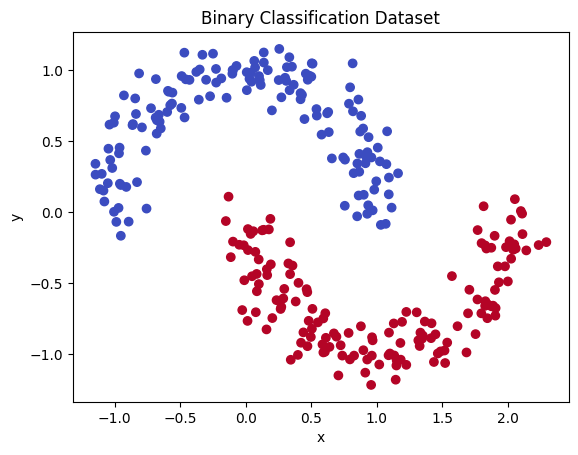

In [64]:
plot_xy(x_unlabeled,y_unlabeled)

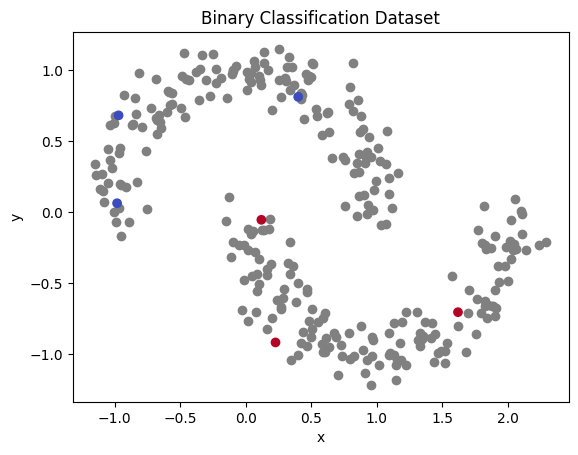

In [65]:
plt.scatter(x_unlabeled[:, 0], x_unlabeled[:, 1], c='gray')
plt.scatter(x_labeled[:, 0], x_labeled[:, 1], c=y_labeled, cmap='coolwarm')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Binary Classification Dataset')
plt.show()

In [66]:
print(x_labeled.shape, y_labeled.shape)
print(x_unlabeled.shape, y_unlabeled.shape)

(6, 2) (6, 1)
(294, 2) (294, 1)


In [67]:
def euclidean_distance(x,y, squared=True):
    x = x[:, None, :]
    y = y[None, :,:]
    dis = np.linalg.norm(x-y, ord=2, axis= -1) # using numpy broadcasting
    if squared:
        return np.power(dis,2)
    return dis

In [68]:
def simirality_weights(x_labeled,x_unlabeled):
    wij = np.exp(-euclidean_distance(x_labeled,x_unlabeled, squared=True))
    w_bar_ij = np.exp(-euclidean_distance(x_unlabeled,x_unlabeled))
    return wij, w_bar_ij

In [69]:
wij,w_bar_ij = simirality_weights(x_labeled,x_unlabeled)
print(wij.shape)
w_bar_ij.shape

(6, 294)


(294, 294)

In [70]:
def initialize_y_unlabeld(y_unlabeled,random_state=42):
    np.random.seed(random_state)
    return np.random.rand(y_unlabeled.shape[0],1) * 0.01

In [71]:
y_unlabeled = initialize_y_unlabeld(y_unlabeled, random_state=42)

In [72]:
def cost_func(wij, w_bar_ij, y_labeled, y_unlabeled):
    
    squared_dif = np.power((y_unlabeled[:,None,:] - y_labeled[None,:,:]).squeeze(),2)    
    term1 = np.sum(wij.T * squared_dif) 
    squared_dif = np.power((y_unlabeled[None,:,:] - y_unlabeled[:,None,:]).squeeze(),2)
    term2 = 0.5 * np.sum(w_bar_ij * squared_dif)
    return term1 + term2

In [73]:
def gradient_of_yj(wij,w_bar_ij, y_labeled,y_unlabeled):
    
    term1 = 2 * np.sum(wij.T * (y_unlabeled[:, None, :] - y_labeled[None,:,:]).squeeze(), axis=1,keepdims=True)
    term2 = 2 * np.sum(w_bar_ij * (y_unlabeled[:, None,:] - y_unlabeled[None,:,:]).squeeze(), axis=1,keepdims=True)
    return term1 + term2

## Gradient Discent

In [74]:
num_iterations = 300
step_size = 0.001
cpu_time_GD = []
y_unlabeled = initialize_y_unlabeld(y_unlabeled)
wij, w_bar_ij = simirality_weights(x_labeled, x_unlabeled)
cost_GD = []


In [75]:
min(y_unlabeled), max(y_unlabeled)

(array([5.06158385e-05]), array([0.00990054]))

In [76]:
start_time = process_time()
for _ in range(num_iterations):
    grad = gradient_of_yj(wij,w_bar_ij, y_labeled,y_unlabeled)
    y_unlabeled -= step_size * grad
    cpu_time_GD.append(process_time() - start_time)
    cost_GD.append(cost_func(wij,w_bar_ij, y_labeled,y_unlabeled))

end_time = process_time()

CPU time 1.140625


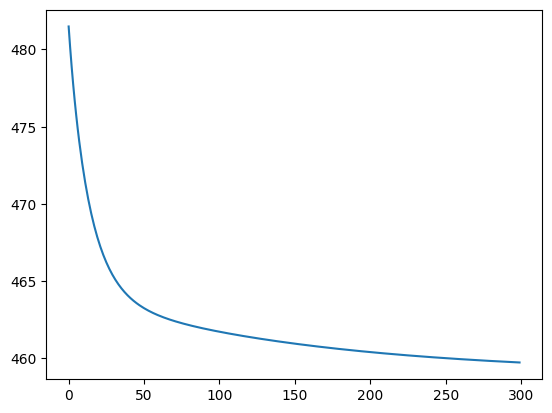

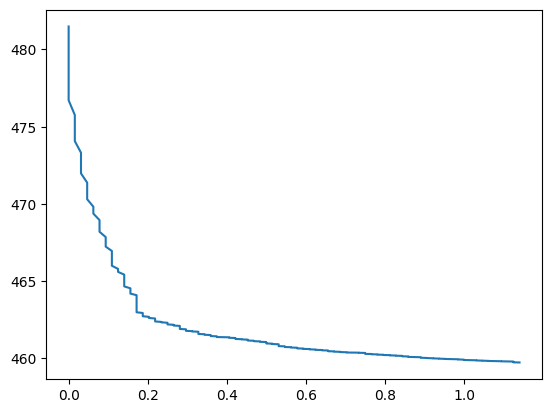

In [77]:
optimization_time = end_time - start_time
print('CPU time', optimization_time)
plt.plot(range(len(cost_GD)),cost_GD)
plt.show()
plt.plot(cpu_time_GD, cost_GD)
plt.show()

In [78]:
min(cost_GD), max(cost_GD)

(459.7405147059608, 481.4890546887243)

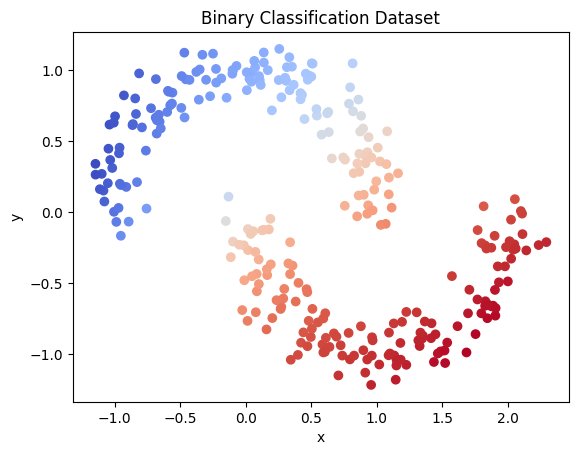

In [79]:
plot_xy(x_unlabeled,y_unlabeled)

### <mark><b>Randomized Block Coordinate Gradient Decent</b></mark>

## mojtaba

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from matplotlib import pyplot
from pandas import DataFrame
from time import process_time
import pandas as pd
from sklearn.utils import fixes
from sklearn.metrics.pairwise import euclidean_distances

In [2]:
# generate 2d classification dataset
np.random.seed(15)
X, y = make_blobs(n_samples=300, centers=2, n_features=2)
x_Unlabeled ,x_labeled_bar,y1,y_label = train_test_split(X,y,test_size=0.02)

print(f"Original size of X= {X.shape[0]}\tUnlabeled size = {x_Unlabeled.shape[0]}\tlabeled size = {x_labeled_bar.shape[0]}")
print(f"Original size of y= {y.shape[0]}\tUnlabeled size = {y1.shape[0]}\tlabeled size = {y_label.shape[0]}")

y_label=y_label*2-1
y_label= y_label.reshape((-1,1))



Original size of X= 300	Unlabeled size = 294	labeled size = 6
Original size of y= 300	Unlabeled size = 294	labeled size = 6


In [10]:
alpha=0.003
num_iterations=300
time_tracking_GD = []

y_unlabel = initialize_y_unlabeld(x_Unlabeled)
wij,wij_bar = simirality_weights(x_labeled_bar,x_Unlabeled)
cost_func_GD = []

In [11]:
y_unlabel.shape, y_label.shape

((294, 1), (6, 1))

In [12]:
t_start = process_time() 

for i in range(num_iterations): 
  derivative = gradient_of_yj(wij,wij_bar,y_label,y_unlabel)
  y_unlabel = y_unlabel-alpha*derivative
  cost_func_GD.append(cost_func(wij,wij_bar,y_label,y_unlabel))
  time_tracking_GD.append(process_time() - t_start)

t_stop = process_time()

Gradient Descend
CPU time: 1.125


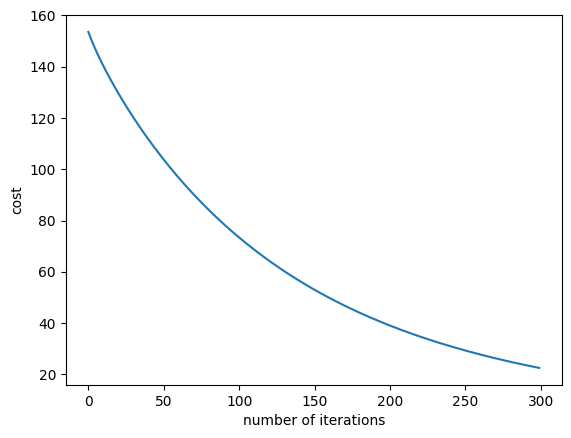

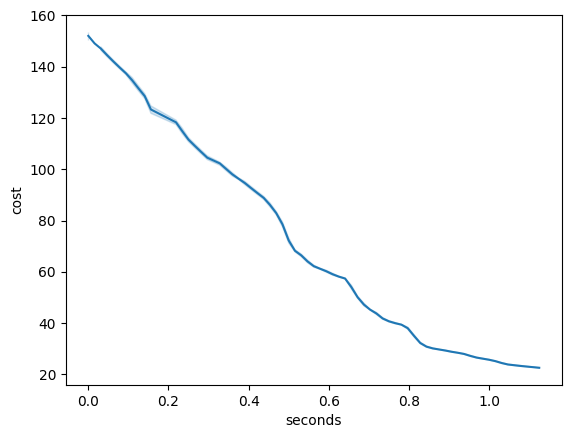

In [13]:
time_GD = t_stop - t_start

print("Gradient Descend")
print("CPU time:", time_GD)

sns.lineplot(x= range(len(cost_func_GD)),y=cost_func_GD)
plt.xlabel("number of iterations")
plt.ylabel("cost")
plt.show()


sns.lineplot(x= time_tracking_GD,y=cost_func_GD)
plt.xlabel("seconds")
plt.ylabel("cost")
plt.show()